## 1. Estimation of the Banana distribution

In this notebook, we will show how we can estimate a density $\pi$ given a limited number of samples $\boldsymbol{x}^i \sim \pi \in \mathbb{R}^{N_x}$. We rely on the adaptive estimation framework developed in Baptista et al. [1].

References: 

[1] Baptista, R., Zahm, O., & Marzouk, Y. (2020). An adaptive transport framework for joint and conditional density estimation. arXiv preprint arXiv:2009.10303.

[2] Marzouk, Y., Moselhy, T., Parno, M., & Spantini, A. (2016). Sampling via measure transport: An introduction. Handbook of uncertainty quantification, 1-41.

In [5]:
using Revise
using LinearAlgebra
using TransportBasedInference
using Statistics
using Distributions

Load some packages to make nice figures

In [2]:
using Plots
default(fontfamily = "Computer Modern",
        tickfont = font("Computer Modern", 9), 
        titlefont = font("Computer Modern", 14), 
        guidefont = font("Computer Modern", 12),
        legendfont = font("Computer Modern", 10),
        grid = false)

using LaTeXStrings

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
┌ Warning: backend `GR` is not installed.
└ @ Plots ~/.julia/packages/Plots/3BCH5/src/backends.jl:43
[ Info: Precompiling FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c]
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


### Problem setup

 We start by generating $N_e$ samples from a banana distribution.

In [3]:
Ne = 500 # Number of samples
Nx = 2 # Dimension of the state

# Define the parameters of the banana distribution
μ = 0.0
σ = 2.0
bananicity = 0.3

# Generate the samples
X = sample_banana(Ne, μ = μ, σ = σ, bananicity = bananicity)

2×500 Matrix{Float64}:
  0.694827  -1.39133    0.107655  …  2.60739    0.396992  -2.60273
 -0.623941  -0.162049  -1.16767      0.466393  -1.69183    0.925165

`X` is an ensemble matrix whose columns are the different ensemble members, i.e. $\boldsymbol{X} = 
\left[ \boldsymbol{x}^1, \ldots, \boldsymbol{x}^{N_e} \right]  \in \mathbb{R}^{N_x \times N_e}$.

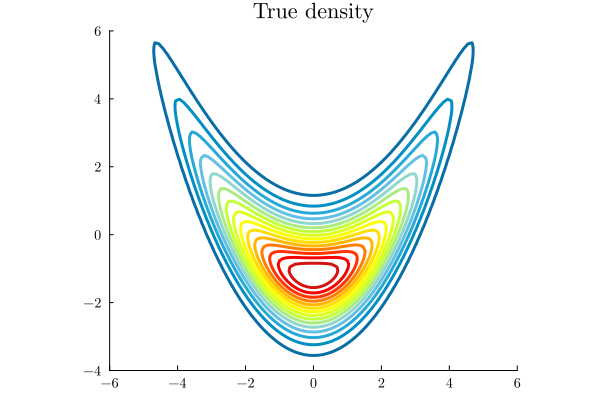

In [4]:
Nlog = 100
logbanana = zeros(Nlog, Nlog)

xrange = range(-6.0; stop = 6.0, length = Nlog)
yrange = range(-4.0; stop = 6.0, length = Nlog)

for (i,x) in enumerate(xrange)
    for (j,y) in enumerate(yrange)
        logbanana[i,j] = log_pdf_banana([x;y]; μ = μ, σ = σ, bananicity = bananicity)
    end
end


contour(xrange, yrange, exp.(logbanana)', ratio = 1,
         title = "True density",
         colorbar = false, grid = false,
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)

We define an object `S` of  type`HermiteMap`to hold the Knothe-Rosenblatt rearrangement that pushes forward $\pi$ to the reference density, i.e. the standard Gaussian distribution $\rho$.
The default constructor for an `HermiteMap` requires $m$ the maximal order of the Hermite polynomials considered in the expansion, $N_x$ the dimension of the state, $L$ a linear transformation that rescale the samples to get zero mean and unitary standard deviation marginally, and $C$ an array of $N_x$ `MapComponent`.

In [6]:
m = 30
S = HermiteMap(m, X; diag = true, b = "CstProHermiteBasis");

The next step is to use the greedy algorithm developed by Baptista et al. (2020) to construct a sparse expansion of the different components of the map $S$. Several kind of optimization are implemented 
depending on the desired robustness of the Knothe-Rosenblatt rearrangement:
* `kfold` uses a k-fold cross validation procedure (the more robust choice but also the longest)
* `split` splits the set of samples into a training and a testing
* An `Int64` to determine the maximum number of features for each component $s^k$ of the map $S$
* `nothing` to simply optimize the existing coefficients in the basis expansion

In [7]:
@time optimize(S, X, "kfold"; withqr = true)

 17.210341 seconds (11.29 M allocations: 28.399 GiB, 5.06% gc time, 41.33% compilation time: <1% of which was recompilation)


Hermite map of dimension 2:
Hermite map component of dimension 1 with Nψ = 1 active features
Hermite map component of dimension 2 with Nψ = 13 active features


The map $S$ is an approximation of the pushforward of the target density $\pi$, to the standard Gaussian density $\rho$.

We can access the different components of the map $S$ as follows:

In [8]:
S[1]

Hermite map component of dimension 1 with Nψ = 1 active features


In [9]:
S[2]

Hermite map component of dimension 2 with Nψ = 13 active features


We can access the coefficients of the expansion for each map component with `getcoeff`.

In [10]:
getcoeff(S[2])

13-element Vector{Float64}:
  12.966566353579577
 -14.3217178370885
   3.413911732106824
  -7.329226878466385
   2.0628586705886063
  -2.3774245671883474
   0.2968936638137862
  -0.4343077223625308
   0.511628557191436
  -4.32501976059603
   0.27440654339506276
  -1.9363598358653547
   0.3610809362460907

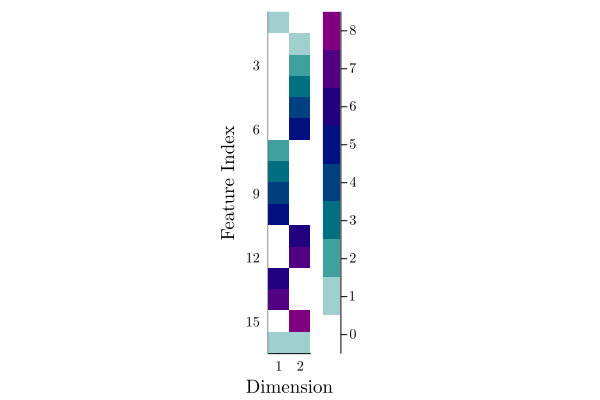

In [35]:
plot(S[2].I.f)

`getidx` can be used to obtain the active features of the different map components. The number of columns is the number of dimensions. Each line correspond to a multi-index for the different components 

In [12]:
getidx(S[1])

1×1 Matrix{Int64}:
 1

Using `PlotRecipes.jl`, we plot the number of occurences of each variable (*columns*) in each map component (*rows*).

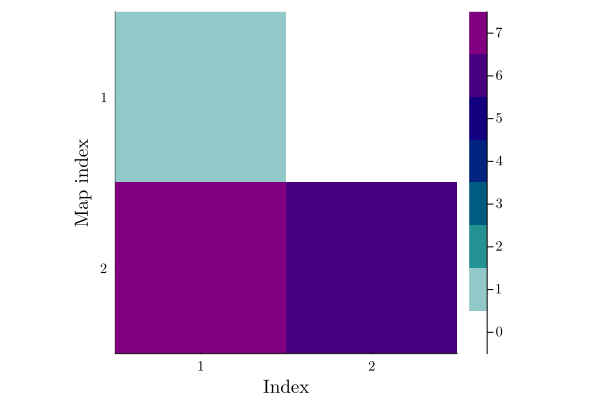

In [13]:
plot(S)

By setting `degree = true`, we plot the maximum multi-index of the features identified for each variable (*columns*) in each map component (*rows*)

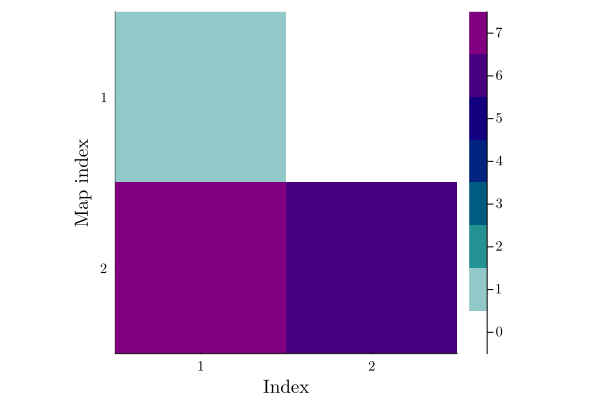

In [14]:
plot(S; degree = true)

  We can now compare the log-density of the true Banana density with the approximated one.

Let's create a grid and evaluate the logarithm of the probability density functions

In [15]:
logbanana_approx = zeros(Nlog, Nlog)
lognormal = zeros(Nlog, Nlog)

for (i,x) in enumerate(xrange)
    for (j,y) in enumerate(yrange)
        logbanana_approx[i,j] = log_pdf(S, reshape([x; y], (2,1)))[1]
        lognormal[i,j] = logpdf(MvNormal(zeros(2), 1.0), [x;y])
    end
end

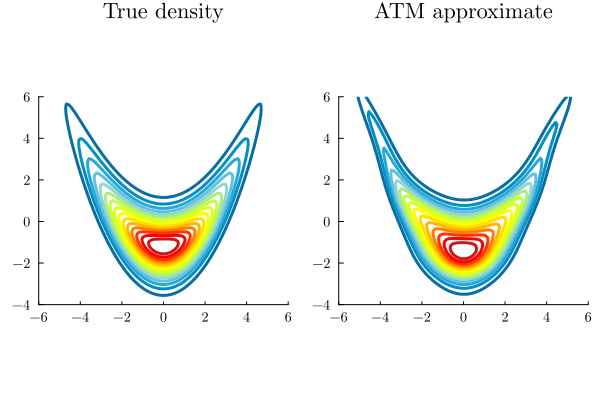

In [26]:
plt = plot(layout = grid(1, 2), colorbar = false, grid = false)
contour!(plt[1,1], xrange, yrange, exp.(logbanana)', ratio = 1,
         title = "True density",
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)

contour!(plt[1,2], xrange, yrange, exp.(logbanana_approx)', ratio = 1,
         title = "ATM approximate",
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)

We can overlap the estimated density with the samples

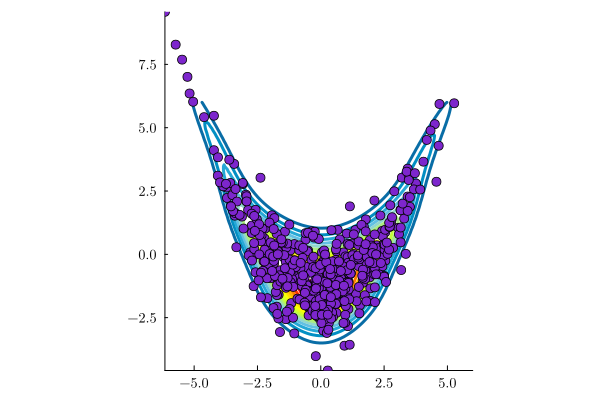

In [17]:
contour(xrange, yrange, exp.(logbanana_approx)', ratio = 1, colorbar = false,
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (-Inf, Inf), ylim = (-Inf, Inf), linewidth = 3)
scatter!(X[1,:], X[2,:]; legend = false, color = :purple3, ratio = 1, markersize = 5)

By definition, the map $S$ pushes forward the samples $\boldsymbol{x}^i$ to the standard normal distribution $\rho$ of $\mathbb{R}^2$, denoted $\boldsymbol{S}_{\sharp} \pi = \rho$,  i.e. $\boldsymbol{x}^i \sim \pi \Rightarrow{} \boldsymbol{S}(\boldsymbol{x}^i) \sim \rho$

In [18]:
SpushX = evaluate(S, X)

2×500 Matrix{Float64}:
 0.353279  -0.69446   0.0583816  0.100118  …   1.31383    0.203696  -1.30286
 0.514806   0.531362  0.125636   1.03762      -0.186348  -0.43317    0.301954

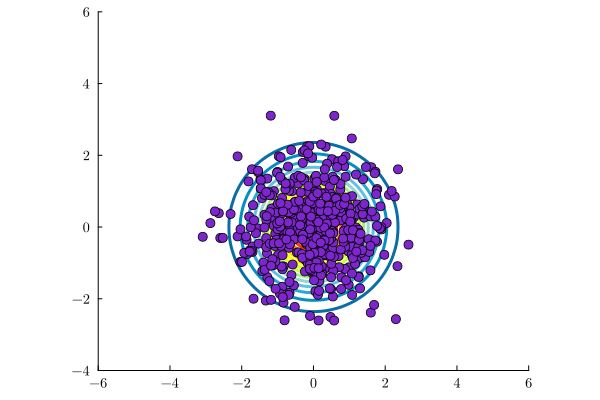

In [19]:
contour(xrange, yrange, exp.(lognormal)', ratio = 1, colorbar = false,
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (-Inf, Inf), ylim = (-Inf, Inf), linewidth = 3)
scatter!(SpushX[1,:], SpushX[2,:]; legend = false, color = :purple3, ratio = 1, markersize = 5)

We can compute the statistics of the pushed samples

In [20]:
mean(SpushX; dims = 2)[:,1] # close to zero

2-element Vector{Float64}:
 -5.5067062021407764e-17
 -8.662665629114963e-5

In [21]:
cov(SpushX; dims = 2) # close to the identity matrix 

2×2 Matrix{Float64}:
  1.0          -0.000401334
 -0.000401334   0.988112

We can use the map $\boldsymbol{S}$ to generate new samples from the target density $\pi$. The map $\boldsymbol{S}$ pulls back  samples $\boldsymbol{z}^i$ of the standard normal distribution $\rho$ to the target density $\pi$, denoted $\boldsymbol{S}^{\sharp} \rho = \pi$, i.e. $\boldsymbol{z}^i \sim \rho \Rightarrow{} \boldsymbol{S}^{-1}(\boldsymbol{z}^i) \sim \pi$.

In [22]:
Znew = randn(Nx, Ne)
Xnew = zeros(Nx, Ne);

We use the in-place routine `inverse` to solve the triangular system $\boldsymbol{S}(\boldsymbol{x}^i) = \boldsymbol{z}^i$ for $\boldsymbol{x}^i \in \mathbb{R}^{N_x}$ for the different samples. From the lower triangular structure of $\boldsymbol{S}$, this inversion reduces to a sequence of one dimensional root finding problems Marzouk et al. [2].

In [23]:
inverse!(Xnew, copy(Znew), S)

2×500 Matrix{Float64}:
 -0.356049   0.57419   2.42805  3.46511  …   1.37395   -0.484098  1.13842
 -0.22189   -0.845016  1.12677  2.73052     -0.836399  -0.775007  0.159649

In [24]:
evaluate(S, Xnew)-Znew

2×500 Matrix{Float64}:
 0.0  0.0  0.0          0.0          0.0  0.0  …  0.0  0.0          0.0  0.0
 0.0  0.0  1.11022e-16  1.11022e-16  0.0  0.0     0.0  1.38778e-17  0.0  0.0

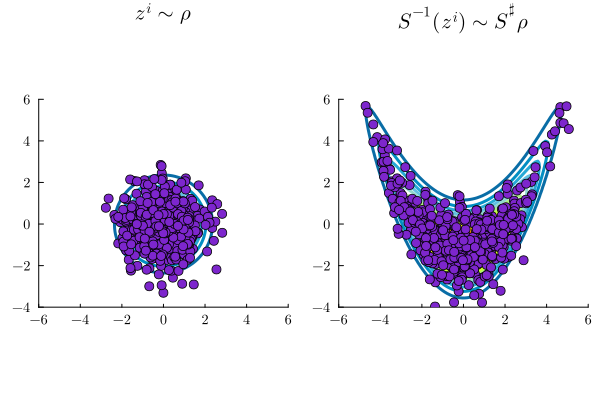

In [25]:
plt = plot(layout = grid(1, 2))

contour!(plt[1,1], xrange, yrange, exp.(lognormal)', ratio = 1, colorbar = false,
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (yrange[1], yrange[end]), linewidth = 3)
scatter!(plt[1,1], Znew[1,:], Znew[2,:]; legend = false, color = :purple3, ratio = 1, markersize = 5, 
         title = L"z^i \sim \rho")

contour!(plt[1,2], xrange, yrange, exp.(logbanana)', ratio = 1, colorbar = false,
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (yrange[1], yrange[end]), linewidth = 3)
scatter!(plt[1,2], Xnew[1,:], Xnew[2,:]; legend = false, color = :purple3, ratio = 1, markersize = 5,
            title = L"S^{-1}(z^i) \sim S^{\sharp}\rho")